# Housing Case Study

### Introduction:

Rasterframes is a powerful tool for combining geospatial data and spark dataframes. In this case study, we will explore the rate of development of a housing complex just outside of Charlottesville, Virginia, using aerial imagery captured over the course of four years. This tutorial assumes a basic knowledge of dataframes; more info can be found [here](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes):

### Background 
![-](pics/cascadia.png)

[Cascadia](http://southern-development.com/communities/cascadia/) is a housing development built to the northeast of Charlottesville. The land was rezoned in 2007, but we are going to analyze how long it took to clear away the forest previously there. This data is available through NAIP (the National Agriculture Imagery Program) and consists of three images taken over the course of 4 years. The pictures have red, green, blue, and near-infrared bands and were taken during the summer of 2012, 2014, and 2016. This is aerial imagery, and has a high spatial resolution, which allows us a more precise measurement of the progression of the development. 

In [1]:
# Initial imports

import pyspark
from pyspark.sql import SparkSession
from pyrasterframes import *
from pyrasterframes.rasterfunctions import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Add other configuration options as needed

spark = SparkSession.builder. \
    master("local[*]"). \
    appName("RasterFrames"). \
    config("spark.ui.enabled", "false"). \
    getOrCreate(). \
    withRasterFrames()
    
bandnums = list(range(1,5))

We import our data from multiple bands using list comprehension and add a column that contains the date in a DateType format.

In [2]:
import pyspark.sql.functions as F
RFs = [spark.read.geotiff("data/201{}.tif".format(i*2)). \
       withColumn("date", F.to_date(F.lit("201{}-01-01".format(i*2)))) for i in range(1,4)]

As we can see, when we imported the geotiff the parser automatically broke the image down into smaller sections. These 
sections are described by the `spatial_key` column, and it appears that there are six multiband tiles for each scene.

We can filter based on date like this:



In [3]:
RFs[0].filter(RFs[0].date == F.to_date(F.lit("2012-01-01"))).show(10)

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|spatial_key|              bounds|            metadata|              tile_1|              tile_2|              tile_3|              tile_4|      date|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|      [1,0]|POLYGON ((724282 ...|Map(TIFFTAG_DATET...|UByteRawArrayTile...|UByteRawArrayTile...|UByteRawArrayTile...|UByteRawArrayTile...|2012-01-01|
|      [0,1]|POLYGON ((724061 ...|Map(TIFFTAG_DATET...|UByteRawArrayTile...|UByteRawArrayTile...|UByteRawArrayTile...|UByteRawArrayTile...|2012-01-01|
|      [2,1]|POLYGON ((724503 ...|Map(TIFFTAG_DATET...|UByteRawArrayTile...|UByteRawArrayTile...|UByteRawArrayTile...|UByteRawArrayTile...|2012-01-01|
|      [0,0]|POLYGON ((724061 ...|Map(TIFFTAG_DATET...|UByteRawArrayTile...|UByteRawArrayTile.

Union joins the three rasterframes vertically, stacking them on top of each other.

In [4]:
from functools import reduce
unionRF = reduce(lambda rf1, rf2: rf1.union(rf2), RFs).asRF()

We change the names of the tile columns (the default format is "tile_#bandnumber#")

In [5]:
for num in bandnums:
    unionRF = unionRF.withColumnRenamed("tile_{}".format(num), "band_{}".format(num))

## Aggregate Statistics

Aggregate statistics are an important tool for the analysis of tiles. Aggregate statistics operate on a columnwise basis, so for instance, `aggSum` finds the sum of all cells within a column, `aggMean` performs a similar function, but finds the mean across every cell in the column. `aggStats` is similar to `tileStats`, except it is aggregated and computes statistics for all cells in a column (for more on aggregate functions, see [aggregate functions](../Minis/agg-functions.html)). This is the result of running `aggStats` across the red band:

In [6]:
unionRF.select(aggStats("band_1")).show(truncate=False)

+-----------------------------------------------------------+
|aggStats(band_1)                                           |
+-----------------------------------------------------------+
|[1014390,0,0.0,255.0,121.22875915574878,2562.4454452519713]|
+-----------------------------------------------------------+



There are 1014390 data cells, 0 `NODATA` Cells, the min value is 23, the max value is 255, the mean is 121.69, and the variance is 2521.36

### Local Aggregate Statistics

Aggregate Statistics will often need to be conducted on a local, or cellwise basis. Local aggregate functions take into account several tiles over one band and output a tile, which has cells equal to that function applied to each cell. For instance, `localAggSum` will return a tile of the same size of the input tiles with the sum of all the cells as the output cells, much in the same way that local arithmetic functions operate (although local aggregated functions can operate on more than two tiles at once). The diagram below represents the process of performing `localAdd` on two tiles where the cells are colored (`localAggSum` is identical, but it operates on any number of tiles). There are other local aggregate functions, such as `localAggMin`, `localAggMax`, `localAggDataCells`, etc.

![-](https://geotrellis.readthedocs.io/en/latest/_images/local-animations-optimized.gif)

## Masking

This tiff is rectangular. However, the construction site is not rectangular. For the sake of both computational speed and the reduction of noise, it makes sense to only query the area we care about (the construction site). In this section we will define the polygon that the construction zone exists in and we will mask the tiles so that the only data present is data that we are interested in (the bounds aren't perfect, but for the sake of simplicity they'll have to do).

WKT is a standard format for describing geometries, and this is the polygon around our construction site. ![Bounding Polygon](pics/withPolygon.png)

In [7]:
wkt = 'POLYGON((724126.644531979574822 4213614.33578644413501, 724188.64699058199767 4213607.733228079043329, 724258.830209883628413 4213571.59410769212991, 724323.732589938445017 4213586.129401290789247, 724448.262392850243486 4213551.541821997612715, 724550.148883086862043 4213550.183335460722446, 724603.129858009982854 4213631.692527649924159, 724649.318400250631385 4213593.654904628172517, 724703.657861710176803 4213343.693381914868951, 724677.170299930498004 4213257.010349686257541, 724638.602859201724641 4213262.724044609814882, 724620.985633189789951 4213180.351609473116696, 724561.467977744177915 4213240.821547405794263, 724485.285378773813136 4213211.776931547559798, 724442.172077926807106 4213245.923298499546945, 724409.61330969678238 4213231.327988603152335, 724366.950096154003404 4213234.6961370408535, 724342.250340945087373 4213266.132189124822617, 724264.782926880638115 4213231.327988603152335, 724203.03353885828983 4213241.432433916255832, 724143.529583127587102 4213296.445525063201785, 724084.025627396884374 4213336.863306314684451, 724126.644531979574822 4213614.33578644413501))'

geomRF = unionRF.withColumn("wkt", F.lit(wkt)) \
.withColumn("polygon", st_geomFromWKT("wkt"))

RasterFrames also provides spatial querying functionality. Here, we tranform the WKT into a polygon. The next step is to rasterize the polygon, so that it can be masked.

In [8]:
geomRF.select("polygon").show(3)

+--------------------+
|             polygon|
+--------------------+
|POLYGON ((724126....|
|POLYGON ((724126....|
|POLYGON ((724126....|
+--------------------+
only showing top 3 rows



However, in order to rasterize the polygon we must determine the dimensions of the raster. Because we will be masking the polygon with our bands, we want to determine the dimensions of our band tiles. We use `tileDimensions` to do that, and we then insert those dimensions into our rasterize function.

In [9]:
geomRF.select(tileDimensions("band_1")).show(5, truncate=False)

+-----------------+
|dimension(band_1)|
+-----------------+
|[221,255]        |
|[221,255]        |
|[221,255]        |
|[221,255]        |
|[221,255]        |
+-----------------+
only showing top 5 rows



In [10]:
maskRF = geomRF.withColumn("maskRaster", rasterize("polygon", "bounds", F.lit(1), 221, 255))

Similarly to `noDataCells`, `aggNoDataCells` returns the number of data cells in our polygon columns that have been set to `NODATA` as a result of our rasterize function. It returns one value because it is aggregating the result of `noDataCells` on each row, of which there are 18 (6 tiles per scene for three scenes).

In [11]:
maskRF.select(aggNoDataCells("maskRaster")).show()

+----------------------------+
|agg_nodata_cells(maskRaster)|
+----------------------------+
|                      429363|
+----------------------------+



It is now time to mask our tiles based on the geometry we have generated. The mask functions compares two tiles, the mask tile and the tile to be masked. Any cells in mask tile that are set to `NODATA` have the corresponding cell in the tile to be masked set to `NODATA`. Any cell in mask tile that is not `NODATA` has the corresponding cell in the tile to be masked untouched. In the example below, the first tile is the mask tile, with black areas representing `NODATA` values. The second tile is the tile to be masked. The third tile is the result of applying the mask, with the area masked set to `NODATA` (for another example of masking, see [masking](../Minis/masking.html). 

![](pics/mask.png)


In this case, the tiles to be masked are our four bands, and the masktile is our maskRaster, which has cell values of 1 or `NODATA`, depending on if the cell is outside of the polygon or not. Since masking requires setting a tile to a value of `NODATA`, the tile cannot have a type of raw. 

In [12]:
maskRF.select(cellType("band_1")).show(1)

+--------------------------+
|celltypeexpression(band_1)|
+--------------------------+
|                  uint8raw|
+--------------------------+
only showing top 1 row



`convertCellType` allows us to change the cell type of the cells in a tile.

In [13]:
for i in bandnums:
    maskRF = maskRF.withColumn("band_{}_ND".format(i), convertCellType("band_{}".format(i), 'uint8'))
    

All better now:

In [14]:
maskRF.select(cellType("band_1_ND")).show(1)

+-----------------------------+
|celltypeexpression(band_1_ND)|
+-----------------------------+
|                        uint8|
+-----------------------------+
only showing top 1 row



Now, time for the actual masking. We go across all four bands, using the band tile as the tile to be masked and the rasterized polygon as the mask tile. 

In [15]:
for i in bandnums:
    maskRF = maskRF \
      .withColumn("masked_{}".format(i), mask(maskRF["band_{}_ND".format(i)], maskRF["maskRaster"])).asRF()        

As we can see, around 2/5 of the data was essentially set to NODATA and discarded because it was outside of the area of interest.

In [16]:
maskRF.select(aggDataCells("masked_1"), aggNoDataCells("masked_1")).show(truncate=False)

+------------------------+--------------------------+
|agg_data_cells(masked_1)|agg_nodata_cells(masked_1)|
+------------------------+--------------------------+
|585027                  |429363                    |
+------------------------+--------------------------+



## Tracking construction progress

While more advanced methods exist, this tutorial will use simple euclidian distance between the cell values of the scenes to determine construction progress. We will analyze the contents of the scenes as an aggregated whole, although a cell by cell implementation would certainly be possible.

In [17]:
scene1RF = maskRF.where(maskRF.date == F.to_date(F.lit("2012-01-01")))
scene2RF = maskRF.where(maskRF.date == F.to_date(F.lit("2014-01-01")))
scene3RF = maskRF.where(maskRF.date == F.to_date(F.lit("2016-01-01")))

Now that the data has been split into three scenes, convert each scene into a vector with each value equal to the mean of each band.

In [18]:
def scene_to_vec(sceneRF):
    return [sceneRF.select(aggMean("masked_{}".format(band))).collect()[0][0] for band in bandnums]

scene1vec = scene_to_vec(scene1RF)
scene2vec = scene_to_vec(scene2RF)
scene3vec = scene_to_vec(scene3RF)

Let's analyze some basic components of these vectors

In [19]:
scene1vec

[88.709598018553, 109.57314277802563, 94.4250214092683, 142.53601115845936]

In [20]:
scene3vec 

[193.9854519534996, 186.72068981431627, 167.3643472865355, 172.76365706198175]

Surprisingly, it seems that the intensity of all four bands has increased, especially the red band, which makes sense because as forest is cleared, more of the red clay soil of the region will be exposed. The band that showed the least increase was the NIR band, which makes sense because a primary source of NIR light is reflectance off of healthy plant life.

### Compare the distance between vectors

In [21]:
# Functions are defined 
def difference(vector1, vector2):
    return [vector1[num-1] - vector2[num-1] for num in bandnums]

def magnitude(vector):
    return (vector[0] ** 2 + vector[1] ** 2 + vector[2] ** 2 + vector[3] ** 2) ** .5

We are now ready to calculate the distance between these aggregated vectors

In [22]:
magnitude(difference(scene3vec, scene1vec)), magnitude(difference(scene3vec, scene2vec)), magnitude(difference(scene2vec, scene1vec))

(152.54050370884383, 129.76139484042068, 22.80963078942201)

Assuming that the transition from forest to cleared forest is somewhat linear, it appears that two years from the scene captured in 2012 they are 15% of the way to completing the clearing of the land, whereas they have totally finished in or before 4 years. This example is meant to be lightweight and simple, but with more data could provide much more precise estimates of construction activity. If we take a few major leaps and assume that we can plot the progression by using the first and last images as starting and ending points and that progression is roughly linear, we can graph the progression with matplotlib.

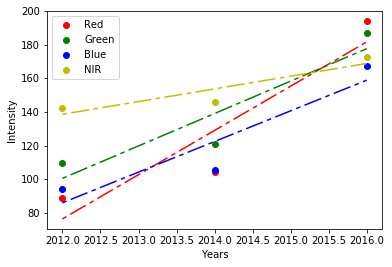

In [23]:
zipped_vecs = list(zip(scene1vec, scene2vec, scene3vec))
zipped_vecs

years = [2012, 2014, 2016]
plt.xlabel("Years")
plt.ylabel("Intensity")

plt.plot(years, zipped_vecs[0], 'ro', label='Red')
plt.plot(years, zipped_vecs[1], 'go', label='Green')
plt.plot(years, zipped_vecs[2], 'bo', label='Blue')
plt.plot(years, zipped_vecs[3], 'yo', label='NIR')
plt.plot(years, np.poly1d(np.polyfit(years, zipped_vecs[0], 1))(years), 'r')[0].set_dashes([3, 3, 12, 3])
plt.plot(years, np.poly1d(np.polyfit(years, zipped_vecs[1], 1))(years), 'g')[0].set_dashes([3, 3, 12, 3])
plt.plot(years, np.poly1d(np.polyfit(years, zipped_vecs[2], 1))(years), 'b')[0].set_dashes([3, 3, 12, 3])
plt.plot(years, np.poly1d(np.polyfit(years, zipped_vecs[3], 1))(years), 'y')[0].set_dashes([3, 3, 12, 3])

plt.legend()
plt.show()

As displayed by this graph, red increased the most, followed by green and blue. While there are not many data points in this analysis, the only thing that would change to incorporate other sources of data would be importing it and changing a few variables. Due to its modularity, RasterFrames has the ability to easily and elastically adapt.